In [34]:
import numpy as np
import pandas as pd
import os
import random
import glob

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from tqdm import tqdm
from unicodedata import normalize
from scipy.spatial import distance

In [2]:
# 기존 listdir + MacOS 시스템으로 인한 (더미 파일(.DS_Store) 제거 + 한글 인식 모듈 변경) 함수
def listdir_ds_remover(dir):
    if os.path.isfile(dir+'/.DS_Store'):
        os.remove(dir+'/.DS_Store')
        list = os.listdir(dir)
        new_list=[]
        for i in list:
            i = normalize("NFC", i)
            new_list.append(i)
        return new_list
    else :
        list = os.listdir(dir)
        new_list=[]
        for i in list:
            i = normalize("NFC", i)
            new_list.append(i)
        return new_list

# font setting
matplotlib.rc('font', family='AppleGothic')

In [ ]:
# dir df 생성
path_origin = '/Users/heemin/Documents/DHLab/mv/project/저학년_landmark'
path_new = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph'
full_list = []
for kid in listdir_ds_remover(path_origin):
    for session in listdir_ds_remover(f'{path_origin}/{kid}'):
        path = f'{path_origin}/{kid}/{session}/'
        full_list.extend(list(map(lambda x:kid+','+session+','+x, listdir_ds_remover(path))))
temp = pd.Series(full_list)
locationFrame = temp.str.split(',',expand=True)
locationFrame.columns = ['kid','session','file']
locationFrame['file_name'] = locationFrame['file'].str.split('.').str[0]
locationFrame['activity'] = locationFrame['file'].str.split('_').str[1]
locationFrame['old_folder'] = locationFrame['kid']+ '/' + locationFrame['session']
locationFrame['new_folder'] = locationFrame['session']+ '/' + locationFrame['activity']
locationFrame['old_file'] =  locationFrame['old_folder'] + '/' + locationFrame['file']
locationFrame['new_file'] =  locationFrame['new_folder'] + '/' + locationFrame['file_name']

# 얼굴 부위 사전화
face_point = {"RIGHT_EYEBROW" : list(range(18, 23)),
                "LEFT_EYEBROW" : list(range(23, 28)), 
                "RIGHT_EYE" : list(range(37, 43)),  
                "LEFT_EYE" : list(range(43, 49)),  
                "NOSE" : list(range(28, 37)),  
                "MOUTH_OUTLINE" : list(range(49, 62)),  
                "MOUTH_INNER" : list(range(62, 69)), 
                "JAWLINE" : list(range(1, 18))}
# # 폴더 생성
# for folder in locationFrame.groupby('session').agg(set)['new_folder'].explode():
#     for section in face_point.keys():
#         os.makedirs(path_new + '/' + folder + '/' + section)

# graph 범주 색상 사전
cname = list(mcolors.TABLEAU_COLORS)
kid_list = list(locationFrame['kid'].unique())
legend_list = random.sample(cname, len(locationFrame['kid'].unique()))
legend_color = {}
for kid, color in zip(kid_list, legend_list):
    legend_color[kid] = color

# point 별 거리 계산
for index in tqdm(range(len(locationFrame))):
    dir = path_origin + '/' + locationFrame['old_file'][index]
    df = pd.read_csv(dir)
    df_index = df[['total_count', 'landmark_count']]
    for  j in range(0,135,2):
        eemo = []
        for i in range(len(df)):
            if not i == 0:
                x1 = df[f'{j}'][i-1]
                y1 = df[f'{j+1}'][i-1]
                my_point=[x1, y1]
                x2 = df[f'{j}'][i]
                y2 = df[f'{j+1}'][i]
                next_point=[x2, y2]
                eemo.append(distance.euclidean(my_point, next_point))
            elif i == 0:
                eemo.append(0)
        eemodf = pd.DataFrame(eemo, columns= [f'{int((j+2)/2)}'])
        df_index = pd.concat([df_index, eemodf], axis=1)
        del eemodf

    # df 저장
    new_csv = path_new + '/' + locationFrame['new_file'][index] + '.csv'
    df_index.to_csv(new_csv)

    # graph 이미지 저장
    new_png = path_new + '/' + locationFrame['new_file'][index]
    for section in face_point.keys():
        num = len(face_point[section])
        fig, axes= plt.subplots(num,1,figsize=(60,2.5*num))
        for i, point in enumerate(face_point[section]):
            axes[i].scatter(df_index['total_count'], df_index[f'{point}'], color=legend_color[locationFrame['kid'][index]])
            axes[i].set_title(f'{point}', fontsize = 18)
        png_dir = path_new + '/' + locationFrame['new_folder'][index] + '/' + section + '/' + locationFrame['file_name'][index]+ '.png'
        plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
        plt.close(fig)

In [48]:
# one point comparison
path_origin = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph'
path_new = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph_one_point'
full_list = []
for session in listdir_ds_remover(path_origin):
    for activity in listdir_ds_remover(f'{path_origin}/{session}'):
        path = rf'{path_origin}/{session}/{activity}/*.csv'
        full_list.extend(list(map(lambda x:session+','+activity+','+x, glob.glob(path))))
temp = pd.Series(full_list)
locationFrame = temp.str.split(',',expand=True)
locationFrame.columns = ['session','activity','dir']
locationFrame['file_name'] = locationFrame['dir'].str.split('/').str[-1]
locationFrame['new_dir'] = locationFrame['activity'] + '/' + locationFrame['session']
locationFrame['kid'] = locationFrame['file_name'].str.split('_').str[-1].str.split('.').str[0]

# 얼굴 부위 사전화
face_one_point = {"RIGHT_EYEBROW" : 18,
                "LEFT_EYEBROW" : 27, 
                "RIGHT_EYE" : 38,  
                "LEFT_EYE" : 45,  
                "RIGHT_MOUTH" : 49,  
                "LEFT_MOUTH" : 65, }

# 폴더 생성
# for folder in locationFrame.groupby('session').agg(set)['new_dir'].explode():
#     os.makedirs(path_new + '/' + folder)

# graph 범주 색상 사전
cname = list(mcolors.TABLEAU_COLORS)
kid_list = list(locationFrame['kid'].unique())
legend_list = random.sample(cname, len(locationFrame['kid'].unique()))
legend_color = {}
for kid, color in zip(kid_list, legend_list):
    legend_color[kid] = color

for section in tqdm(list(face_one_point.keys()), desc='point'):

    for activity in list(locationFrame['activity'].unique()):
        for session in list(locationFrame['session'].unique()):
            try:
                l1 = locationFrame.groupby([locationFrame['activity']==activity, locationFrame['session']==session]).agg(list)['dir'][1][1]
                l2 = locationFrame.groupby([locationFrame['activity']==activity, locationFrame['session']==session]).agg(list)['new_dir'][1][1]
                num = len(l1)
                fig, axes= plt.subplots(num,1,figsize=(60,6*num))
                new_png = path_new + '/' + l2[0]
                point = face_one_point[section]
                for index in range(len(l1)):
                    df = pd.read_csv(l1[index])
                    axes[index].scatter(df['total_count'], df[f'{point}'], color=legend_color[kid_list[index]], label=kid_list[index])
                    axes[index].set_title(kid_list[index], fontsize = 25)
                    axes[index].legend(markerscale=5., fontsize = 35)
                fig.suptitle(activity + '_' + session + '_' + section, fontweight ="bold", fontsize = 35) 
                png_dir = new_png + '/' + activity + '_' + session + '_' + section + '.png'
                plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
                plt.close(fig)
            except:
                pass

point:  33%|███▎      | 2/6 [00:43<01:26, 21.61s/it]/var/folders/sc/sg8zc8mj6630dt6_wh5ffjvr0000gn/T/ipykernel_94969/633308908.py:54: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
point:  50%|█████     | 3/6 [01:04<01:04, 21.37s/it]/var/folders/sc/sg8zc8mj6630dt6_wh5ffjvr0000gn/T/ipykernel_94969/633308908.py:54: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
point:  67%|██████▋   | 4/6 [01:25<00:42, 21.28s/it]/var/folders/sc/sg8zc8mj6630dt6_wh5ffjvr0000gn/T/ipykernel_94969/633308908.py:54: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
point: 100%|██████████| 6/6 [02:08<00:00, 21.41s/it]


In [6]:
path_origin = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph'
path_new = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph_one_point'
full_list = []
for session in listdir_ds_remover(path_origin):
    for activity in listdir_ds_remover(f'{path_origin}/{session}'):
        path = rf'{path_origin}/{session}/{activity}/*.csv'
        full_list.extend(list(map(lambda x:session+','+activity+','+x, glob.glob(path))))
temp = pd.Series(full_list)
locationFrame = temp.str.split(',',expand=True)
locationFrame.columns = ['session','activity','dir']
locationFrame['file_name'] = locationFrame['dir'].str.split('/').str[-1]
locationFrame['new_dir'] = locationFrame['session'] + '/' + locationFrame['activity']
locationFrame['kid'] = locationFrame['file_name'].str.split('_').str[-1].str.split('.').str[0]

# 얼굴 부위 사전화
face_one_point = {"RIGHT_EYEBROW" : 18,
                "LEFT_EYEBROW" : 27, 
                "RIGHT_EYE" : 38,  
                "LEFT_EYE" : 45,  
                "RIGHT_MOUTH" : 49,  
                "LEFT_MOUTH" : 65, }

# graph 범주 색상 사전
cname = list(mcolors.TABLEAU_COLORS)
kid_list = list(locationFrame['kid'].unique())
legend_list = random.sample(cname, len(locationFrame['kid'].unique()))
legend_color = {}
for kid, color in zip(kid_list, legend_list):
    legend_color[kid] = color

In [40]:
section = list(face_one_point.keys())[0]
activity = '3분전'
session = '1session'
matplotlib.rc('font', family='AppleGothic')
try:
    l1 = locationFrame.groupby([locationFrame['activity']==activity, locationFrame['session']==session]).agg(list)['dir'][1][1]
    l2 = locationFrame.groupby([locationFrame['activity']==activity, locationFrame['session']==session]).agg(list)['new_dir'][1][1]
    num = len(l1)
    fig, axes= plt.subplots(num,1,figsize=(60,6*num))
    new_png = path_new + '/' + l2[0]
    point = face_one_point[section]
    for index in range(len(l1)):
        df = pd.read_csv(l1[index])
        axes[index].scatter(df['total_count'], df[f'{point}'], color=legend_color[kid_list[index]], label=kid_list[index])
        axes[index].set_title(kid_list[index], fontsize = 20)
        axes[index].legend(markerscale=5., fontsize = 35)
    fig.suptitle(activity + '_' + session + '_' + section, fontweight ="bold", fontsize = 35) 
    png_dir = new_png + '/' + section + '/' + activity + '_' + session + '_' + section + '.png'
    plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
    plt.close(fig)
except:
    pass

In [41]:
path_origin = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph'
path_new = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph_one_point'
full_list = []
for session in listdir_ds_remover(path_origin):
    for activity in listdir_ds_remover(f'{path_origin}/{session}'):
        path = rf'{path_origin}/{session}/{activity}/*.csv'
        full_list.extend(list(map(lambda x:session+','+activity+','+x, glob.glob(path))))
temp = pd.Series(full_list)
locationFrame = temp.str.split(',',expand=True)
locationFrame.columns = ['session','activity','dir']
locationFrame['file_name'] = locationFrame['dir'].str.split('/').str[-1]
locationFrame['new_dir'] = locationFrame['session'] + '/' + locationFrame['activity']
locationFrame['kid'] = locationFrame['file_name'].str.split('_').str[-1].str.split('.').str[0]

# 얼굴 부위 사전화
face_one_point = {"RIGHT_EYEBROW" : 18,
                "LEFT_EYEBROW" : 27, 
                "RIGHT_EYE" : 38,  
                "LEFT_EYE" : 45,  
                "RIGHT_MOUTH" : 49,  
                "LEFT_MOUTH" : 65, }

# 폴더 생성
# for folder in locationFrame.groupby('session').agg(set)['new_dir'].explode():
#     for section in face_one_point.keys():
#         os.makedirs(path_new + '/' + folder + '/' + section)

# graph 범주 색상 사전
cname = list(mcolors.TABLEAU_COLORS)
kid_list = list(locationFrame['kid'].unique())
legend_list = random.sample(cname, len(locationFrame['kid'].unique()))
legend_color = {}
for kid, color in zip(kid_list, legend_list):
    legend_color[kid] = color

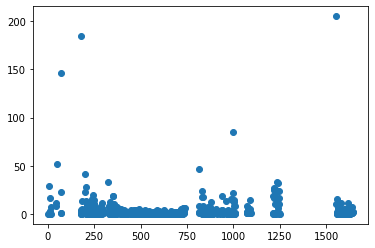

In [42]:
plt.scatter(df['total_count'], df[f'{point}'], color=legend_color[kid_list[index]])

In [37]:
kid_list

['HJY', 'LJH', 'KSY', 'LYG', 'PSG', ' HJY']

KeyError: '4session/휴식2'

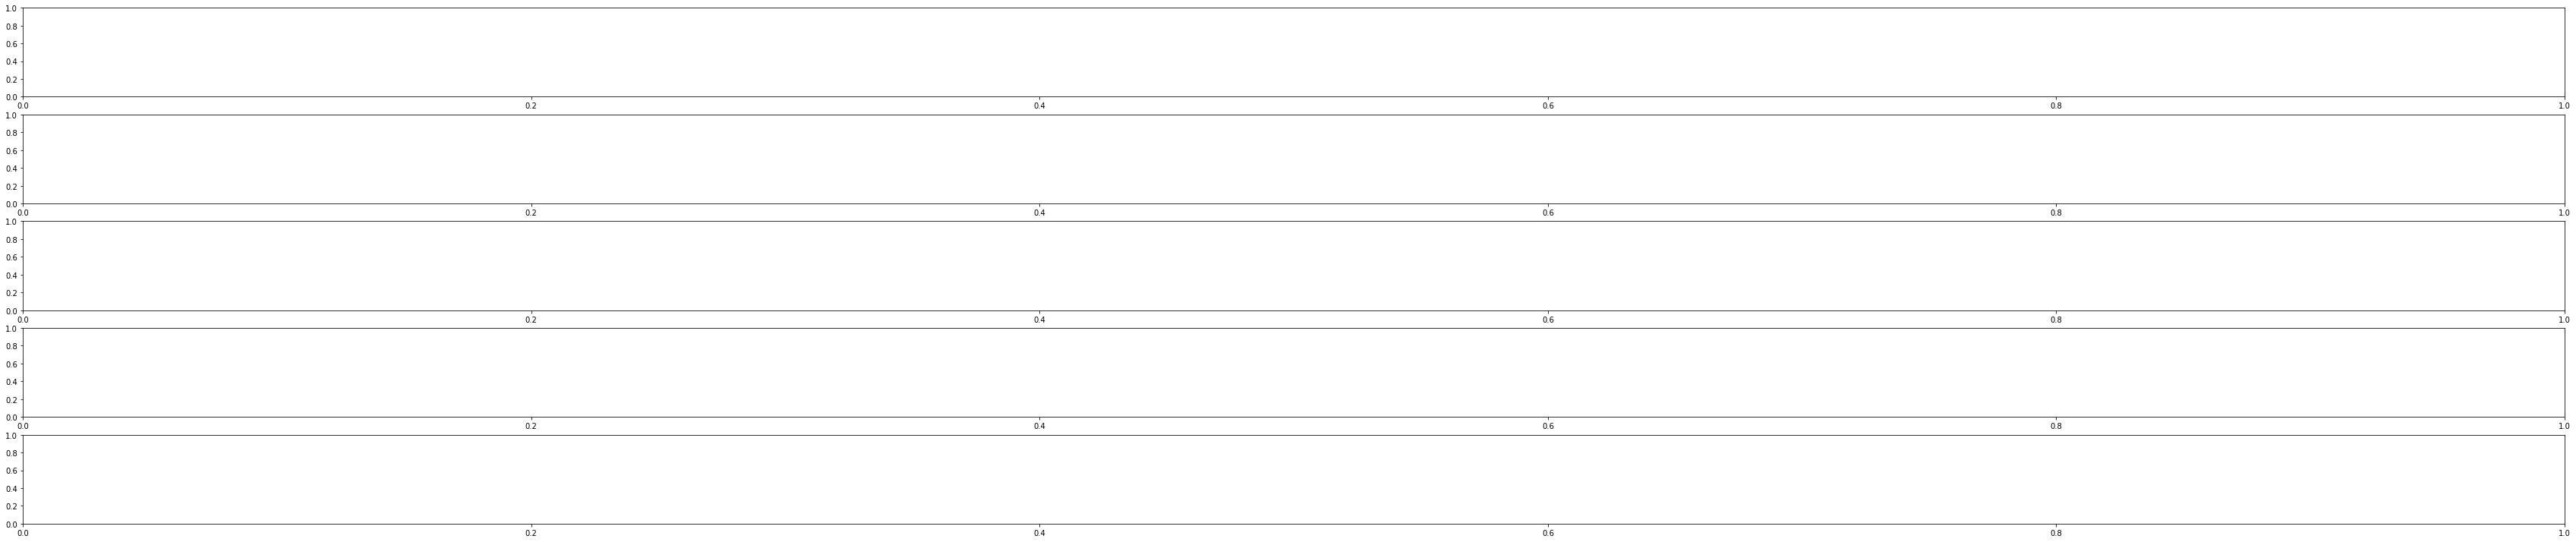

In [40]:
fig, axes= plt.subplots(5,1,figsize=(60,2.5*5))
df = pd.read_csv(l1[0])
axes[0].scatter(df['total_count'], df[f'{point}'], color=legend_color[kid_list[0]])
axes[0].set_title(f'{point}', fontsize = 18)

In [17]:
list(face_one_point.keys())[0]

'RIGHT_EYEBROW'

KeyError: '4session/휴식2'

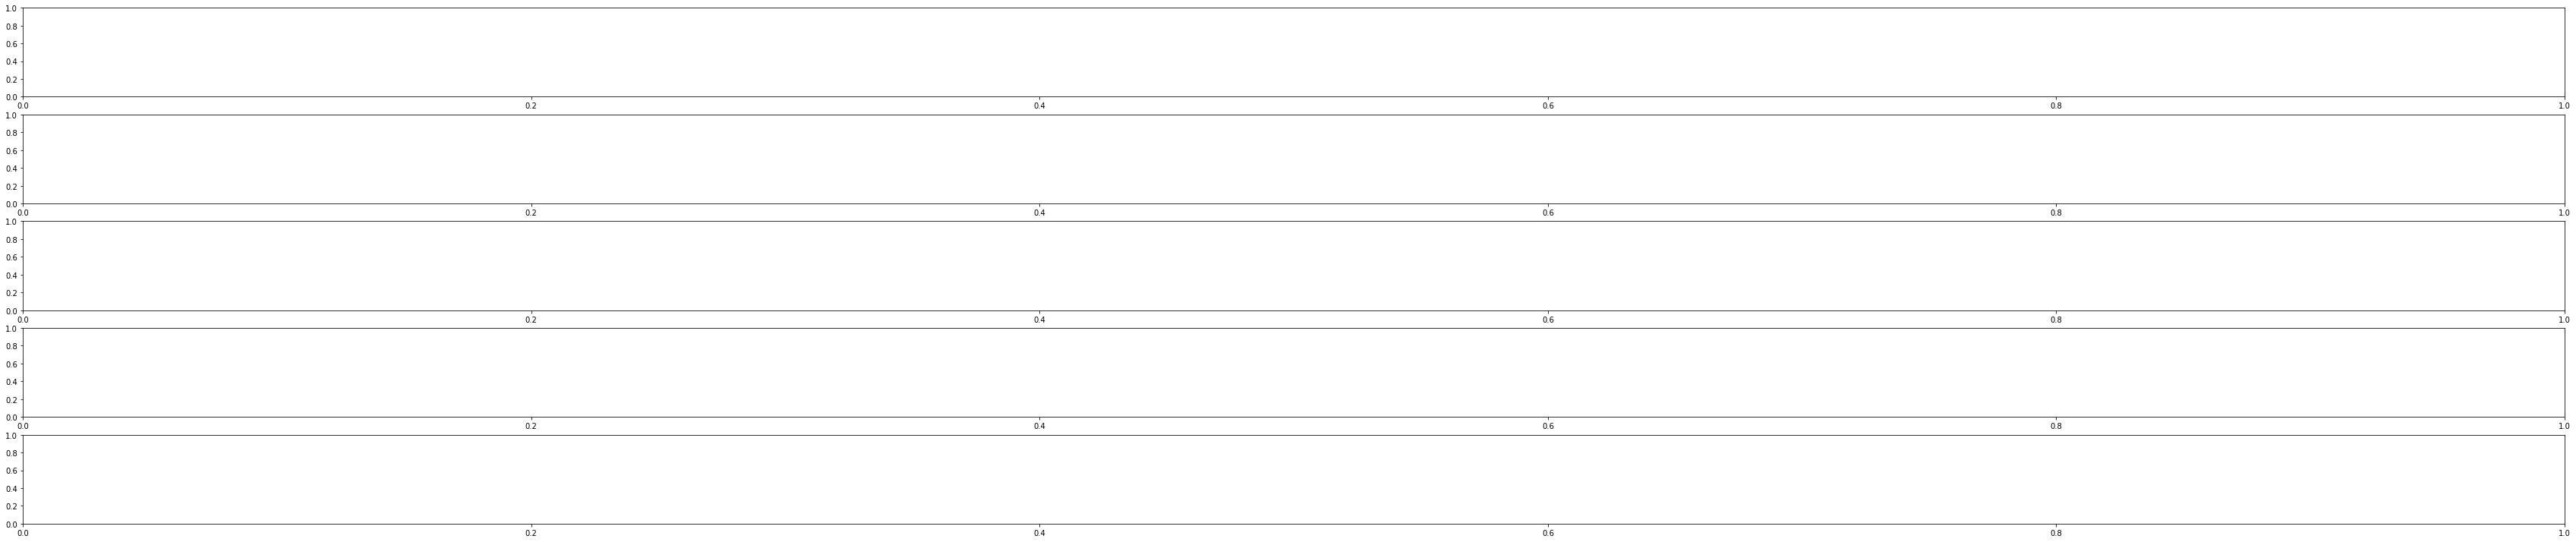

In [14]:
fig, axes= plt.subplots(num,1,figsize=(60,2.5*num))
df = pd.read_csv(l1[0])
index = 0
axes[index].scatter(df['total_count'], df[f'{point}'], color=legend_color[kid_list[index]])
axes[index].set_title(f'{point}', fontsize = 18)

In [188]:
activity = '3분전'
session = '1session'
l1 = locationFrame.groupby([locationFrame['activity']==activity, locationFrame['session']==session]).agg(list)[['dir']]

In [195]:
locationFrame.groupby([locationFrame['activity']==activity, locationFrame['session']==session]).agg(list)['dir'][1][1]

['/Users/heemin/Documents/DHLab/mv/project/저학년_graph/1session/3분전/session1_3분전_PSG.csv',
 '/Users/heemin/Documents/DHLab/mv/project/저학년_graph/1session/3분전/session1_3분전_LYG.csv',
 '/Users/heemin/Documents/DHLab/mv/project/저학년_graph/1session/3분전/session1_3분전_KSY.csv',
 '/Users/heemin/Documents/DHLab/mv/project/저학년_graph/1session/3분전/session1_3분전_LJH.csv',
 '/Users/heemin/Documents/DHLab/mv/project/저학년_graph/1session/3분전/session1_3분전_HJY.csv']

In [192]:
l1

dir
activity session                                                   
False    False    [/Users/heemin/Documents/DHLab/mv/project/저학년_...
         True     [/Users/heemin/Documents/DHLab/mv/project/저학년_...
True     False    [/Users/heemin/Documents/DHLab/mv/project/저학년_...
         True     [/Users/heemin/Documents/DHLab/mv/project/저학년_...

In [ ]:
 png_dir = path_new + '/' + locationFrame['new_folder'][index] + '/' + section + '/' + locationFrame['file_name'][index]+ '.png'
        plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
        plt.close(fig)

In [177]:
locationFrame.groupby([locationFrame['activity']=='3분후', locationFrame['session']=='1session']).agg(list)[['kid', 'file_name']]

kid  \
activity session                                                      
False    False    [HJY, LJH, KSY, LYG, PSG, LJH, HJY, KSY, PSG, ...   
         True     [LYG, PSG, KSY, LJH, HJY, PSG, LYG, KSY, LJH, ...   
True     False    [KSY, LJH, HJY, PSG, LYG, KSY, HJY, LJH, LYG, ...   
         True                             [HJY, LJH, KSY, LYG, PSG]   

                                                          file_name  
activity session                                                     
False    False    [session3_metaverse1_HJY.csv, session3_metaver...  
         True     [session1_metaverse1_LYG.csv, session1_metaver...  
True     False    [session3_3분후_KSY.csv, session3_3분후_LJH.csv, s...  
         True     [session1_3분후_HJY.csv, session1_3분후_LJH.csv, s...

In [141]:
face_one_point.keys()

dict_keys(['RIGHT_EYEBROW', 'LEFT_EYEBROW', 'RIGHT_EYE', 'LEFT_EYE', 'RIGHT_MOUTH', 'LEFT_MOUTH'])

In [ ]:
ii = [i for i in os.listdir(폴더경로) if '찾을 단어' in i]

In [79]:
df

,Unnamed: 0,total_count,landmark_count,1,2,3,4,5,6,7,...,59,60,61,62,63,64,65,66,67,68
0,0,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,2,3.162278,2.828427,4.123106,4.000000,5.099020,4.472136,4.472136,...,5.656854,3.162278,1.414214,3.605551,5.385165,5.385165,3.605551,7.211103,5.000000,4.242641
2,2,3,3,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.236068,1.414214,1.000000,0.000000,1.414214,1.414214,2.236068,2.236068,1.000000,1.000000
3,3,4,4,1.000000,1.000000,1.000000,1.000000,1.414214,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
4,4,5,5,5.099020,4.123106,3.162278,3.162278,2.236068,1.414214,1.414214,...,3.605551,2.828427,3.605551,1.414214,1.000000,2.236068,1.414214,3.000000,3.162278,3.605551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,1585,1675,1586,1.000000,1.414214,0.000000,0.000000,1.000000,1.000000,1.414214,...,1.000000,1.000000,1.414214,1.000000,1.000000,1.414214,1.414214,2.000000,2.000000,1.414214
1586,1586,1676,1587,3.000000,2.236068,2.236068,1.000000,2.000000,2.236068,3.000000,...,1.000000,2.000000,3.000000,1.000000,1.414214,1.000000,1.000000,1.000000,2.000000,1.000000
1587,1587,1677,1588,1.414214,1.000000,1.000000,2.236068,2.828427,2.236068,2.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.414214
1588,1588,1678,1589,2.236068,2.000000,2.000000,1.414214,1.000000,1.414214,1.414214,...,1.000000,1.000000,1.414214,1.414214,1.414214,1.000000,1.000000,0.000000,1.000000,1.414214


In [80]:
locationFrame

,session,kid,dir,file_name,activity,new_dir
0,1session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session1_3분후_HJY.csv,3분후,1session/3분후
1,1session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session1_3분후_LJH.csv,3분후,1session/3분후
2,1session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session1_3분후_KSY.csv,3분후,1session/3분후
3,1session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session1_3분후_LYG.csv,3분후,1session/3분후
4,1session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session1_3분후_PSG.csv,3분후,1session/3분후
...,...,...,...,...,...,...
115,4session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session4_휴식1_PSG.csv,휴식1,4session/휴식1
116,4session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session4_휴식1_LYG.csv,휴식1,4session/휴식1
117,4session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session4_휴식1_KSY.csv,휴식1,4session/휴식1
118,4session,LYG,/Users/heemin/Documents/DHLab/mv/project/저학년_g...,session4_휴식1_LJH.csv,휴식1,4session/휴식1


In [ ]:
# one point graph
# dir df 생성
path_origin = '/Users/heemin/Documents/DHLab/mv/project/저학년_landmark'
path_new = '/Users/heemin/Documents/DHLab/mv/project/저학년_graph'
full_list = []
for kid in listdir_ds_remover(path_origin):
    for session in listdir_ds_remover(f'{path_origin}/{kid}'):
        path = f'{path_origin}/{kid}/{session}/'
        full_list.extend(list(map(lambda x:kid+','+session+','+x, listdir_ds_remover(path))))
temp = pd.Series(full_list)
locationFrame = temp.str.split(',',expand=True)
locationFrame.columns = ['kid','session','file']
locationFrame['file_name'] = locationFrame['file'].str.split('.').str[0]
locationFrame['activity'] = locationFrame['file'].str.split('_').str[1]
locationFrame['old_folder'] = locationFrame['kid']+ '/' + locationFrame['session']
locationFrame['new_folder'] = locationFrame['session']+ '/' + locationFrame['activity']
locationFrame['old_file'] =  locationFrame['old_folder'] + '/' + locationFrame['file']
locationFrame['new_file'] =  locationFrame['new_folder'] + '/' + locationFrame['file_name']

# 얼굴 부위 사전화
face_one_point = {"RIGHT_EYEBROW" : 18,
                "LEFT_EYEBROW" : 27, 
                "RIGHT_EYE" : 38,  
                "LEFT_EYE" : 45,  
                "RIGHT_MOUTH" : 49,  
                "LEFT_MOUTH" : 65, }
# # 폴더 생성
# for folder in locationFrame.groupby('session').agg(set)['new_folder'].explode():
#     for section in face_point.keys():
#         os.makedirs(path_new + '/' + folder + '/' + section)

# graph 범주 색상 사전
cname = list(mcolors.TABLEAU_COLORS)
kid_list = list(locationFrame['kid'].unique())
legend_list = random.sample(cname, len(locationFrame['kid'].unique()))
legend_color = {}
for kid, color in zip(kid_list, legend_list):
    legend_color[kid] = color

# point 별 거리 계산
for index in tqdm(range(len(locationFrame))):
    dir = path_origin + '/' + locationFrame['old_file'][index]
    df = pd.read_csv(dir)
    df_index = df[['total_count', 'landmark_count']]
    for  j in range(0,135,2):
        eemo = []
        for i in range(len(df)):
            if not i == 0:
                x1 = df[f'{j}'][i-1]
                y1 = df[f'{j+1}'][i-1]
                my_point=[x1, y1]
                x2 = df[f'{j}'][i]
                y2 = df[f'{j+1}'][i]
                next_point=[x2, y2]
                eemo.append(distance.euclidean(my_point, next_point))
            elif i == 0:
                eemo.append(0)
        eemodf = pd.DataFrame(eemo, columns= [f'{int((j+2)/2)}'])
        df_index = pd.concat([df_index, eemodf], axis=1)
        del eemodf

    # df 저장
    new_csv = path_new + '/' + locationFrame['new_file'][index] + '.csv'
    df_index.to_csv(new_csv)

    # graph 이미지 저장
    new_png = path_new + '/' + locationFrame['new_file'][index]
    for section in face_point.keys():
        num = len(face_point[section])
        fig, axes= plt.subplots(num,1,figsize=(60,2.5*num))
        for i, point in enumerate(face_one_point[section]):
            axes[i].scatter(df_index['total_count'], df_index[f'{point}'], color=legend_color[locationFrame['kid'][index]])
            axes[i].set_title(f'{point}', fontsize = 18)
        png_dir = path_new + '/' + locationFrame['new_folder'][index] + '/' + section + '/' + locationFrame['file_name'][index]+ '.png'
        plt.savefig(png_dir, dpi=100, facecolor='#eeeeee',bbox_inches='tight')
        plt.close(fig)

In [2]:
RIGHT_EYEBROW = list(range(17, 22))  
LEFT_EYEBROW = list(range(22, 27))  
RIGHT_EYE = list(range(36, 42))  
LEFT_EYE = list(range(42, 48))  
NOSE = list(range(27, 36))  
MOUTH_OUTLINE = list(range(48, 61))  
MOUTH_INNER = list(range(61, 68)) 
JAWLINE = list(range(0, 17)) 

In [13]:
os.getcwd()

'/Users/heemin/Documents/DHLab/mv/project/code'

In [7]:
dir = '/Users/heemin/Documents/DHLab/mv/project/저학년_landmark/HJY/1session/session1_3분전_HJY.csv'
df = pd.read_csv(dir)
df_index = df[['total_count', 'landmark_count']]
for  j in range(0,135,2):
    eemo = []
    for i in range(len(df)):
        if not i == 0:
            x1 = df[f'{j}'][i-1]
            y1 = df[f'{j+1}'][i-1]
            my_point=[x1, y1]
            x2 = df[f'{j}'][i]
            y2 = df[f'{j+1}'][i]
            next_point=[x2, y2]
            eemo.append(distance.euclidean(my_point, next_point))
        elif i == 0:
            eemo.append(0)
    eemodf = pd.DataFrame(eemo, columns= [f'{int((j+2)/2)}'])
    df_index = pd.concat([df_index, eemodf], axis=1)
    del eemodf

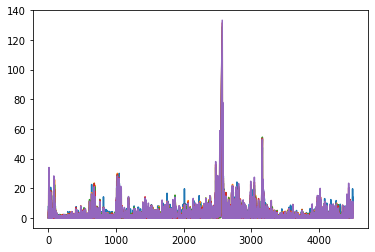

In [8]:
for point in RIGHT_EYEBROW:
    exec(f'plt.plot(df_index[\'total_count\'], df_index[\'{point}\'])')

In [14]:
section = RIGHT_EYEBROW
num = len(section)
fig, axes= plt.subplots(num,1,figsize=(60,2.5*num))
for i, point in enumerate(section):
    axes[i].plot(df_index['total_count'], df_index[f'{point}'])
    axes[i].set_title(f'{point}', fontsize = 18)
plt.savefig(f'{section}.png',dpi=100, facecolor='#eeeeee',bbox_inches='tight')
plt.close(fig)

In [23]:
fig = plt.figure(figsize=(15,3))

<Figure size 1080x216 with 0 Axes>

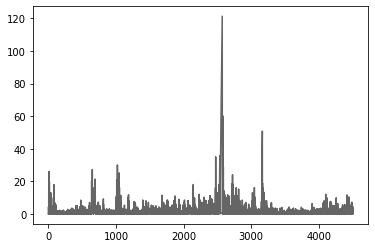

In [15]:
plt.plot(df_index['total_count'], df_index['49'], color='#656565')